<a href="https://colab.research.google.com/github/GoodSairon/Studyspace_Sairon/blob/main/55.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
#from model import discriminator, generator
import numpy as np
import matplotlib.pyplot as plt

In [10]:
z_dim = 100

class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(128, 1024),
            nn.Li(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 784),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        return x

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        out = self.fc(x)
        return out

In [11]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


"""
Hyperparameter settings
"""
epochs = 150
lr = 2e-4
batch_size = 64
loss = nn.BCELoss()

# Model
G = generator().to(device)
D = discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


"""
Image transformation and dataloader creation
Note that we are training generation and not classification, and hence
only the train_loader is loaded
"""
# Transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Load data
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

In [12]:
"""
Процедура обучения сети.
Каждый шаг потери обновляется как для дискиминатора, так и для генератора.
Дискриминатор стремится классифицировать реальные и fakes
Генератор стремится генерировать как можно более реалистичные изображения
"""
epochs = 100
for epoch in range(epochs):
    for idx, (imgs, _) in enumerate(train_loader):
        idx += 1
        # Обучаем дискриминатор
        # real_inputs - изображения из набора данных MNIST
        # fake_inputs - изображения от генератора
        # real_inputs должны быть классифицированы как 1, а fake_inputs - как 0
        real_inputs = imgs.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)
        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)
        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)
        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        # Обучаем генератор
        # Цель генератора получить от дискриминатора 1 по всем изображениям
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))
    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

Epoch 0 Iteration 100: discriminator_loss 0.692 generator_loss 0.825
Epoch 0 Iteration 200: discriminator_loss 0.719 generator_loss 0.941
Epoch 0 Iteration 300: discriminator_loss 0.527 generator_loss 1.195
Epoch 0 Iteration 400: discriminator_loss 0.432 generator_loss 1.459
Epoch 0 Iteration 500: discriminator_loss 0.394 generator_loss 2.150
Epoch 0 Iteration 600: discriminator_loss 0.191 generator_loss 2.516
Epoch 0 Iteration 700: discriminator_loss 0.361 generator_loss 1.700
Epoch 0 Iteration 800: discriminator_loss 0.403 generator_loss 1.499
Epoch 0 Iteration 900: discriminator_loss 0.246 generator_loss 2.572
Epoch 0 Iteration 938: discriminator_loss 0.223 generator_loss 3.282
Epoch 1 Iteration 100: discriminator_loss 0.205 generator_loss 2.346
Epoch 1 Iteration 200: discriminator_loss 0.400 generator_loss 3.848
Epoch 1 Iteration 300: discriminator_loss 0.158 generator_loss 2.480
Epoch 1 Iteration 400: discriminator_loss 0.356 generator_loss 3.274
Epoch 1 Iteration 500: discriminat

In [16]:
x = G.forward(noise).cpu().detach().numpy()
x

array([[-1.        , -1.        , -0.99999994, ..., -0.99996674,
        -1.        , -1.        ],
       [-0.9999857 , -0.9999996 , -0.9999959 , ..., -0.9999975 ,
        -0.98863053, -0.9999998 ],
       [-0.9999842 , -0.9999992 , -0.99999976, ..., -0.99999815,
        -0.99997646, -0.99997795],
       ...,
       [-0.99999994, -0.9999998 , -0.99999875, ..., -0.9958613 ,
        -0.9999926 , -0.999949  ],
       [-0.99922806, -0.99991447, -0.9998827 , ..., -0.99947685,
        -0.9995424 , -0.99948996],
       [-0.9999982 , -0.99999887, -0.9999918 , ..., -0.9999926 ,
        -0.9999988 , -0.9995562 ]], dtype=float32)

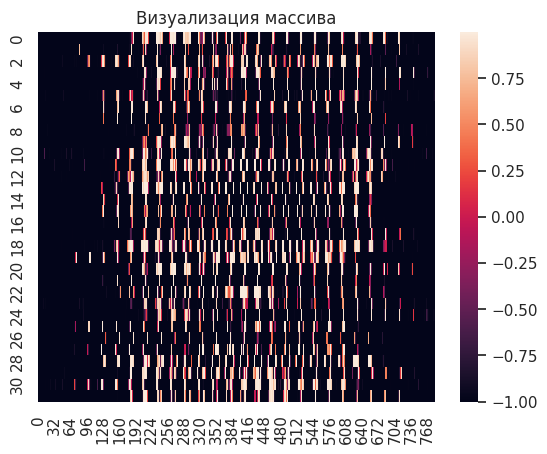

In [18]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

ax = sns.heatmap(x)
plt.title("Визуализация массива",fontsize=12)
plt.savefig("visual_numpy_array.png", bbox_inches='tight', dpi=100)
plt.show()